# **CS 1810 Homework 5**
---
To account for potential version issues, try the following in your terminal:

1. Create a new environment with `python3 -m venv venv`
2. Activate that environment with `source venv/bin/activate`
3. Make sure the interpreter in the top right corner of your VSCode (or whatever you use to run your code is venv).
4. If you get a "install kernel" message, press it.
5. Run `pip install -r requirements.txt`
6. Run the remainder of this notebook.

Note that this is not necessary but can help prevent any issues due to package versions.

**The following notebook is meant to help you work through Problems 2 and 3 on Homework 5. You are by no means required to use it, nor are you required to fill out/use any of the boilerplate code/functions. You are welcome to implement the functions however you wish.**


## Problem 2

#### Initialize data and parameters

Consider a specific example of when we have $K = 3$ component Gamma distributions. Let's initialize the initial parameter values for $\theta$ and $\beta_k$ as follows:
$$
\begin{align*}
  \theta_k &=  1/K, \\
  \beta_k & = k/K.
\end{align*}
$$

Note that we usually initialize $\theta$ and $\beta_k$ randomly. However, by fixing the initial $\theta$ and $\beta_k$, EM becomes deterministic which makes debugging (and grading) easier.



In [63]:
import torch
import torch.distributions as ds
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [64]:
# Load in the data
x = torch.load('data.pt').reshape((-1, 1))

# # uncomment to use numpy (optional)
# import numpy as np
# from scipy.stats import gamma
# x = x.numpy()
# theta = theta.numpy()
# betas = betas.numpy()

### Part 1

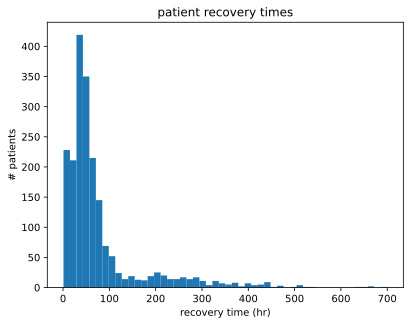

In [65]:
plt.hist(x, bins=50)
plt.xlabel("recovery time (hr)")
plt.ylabel("# patients")
plt.title("patient recovery times")
plt.savefig("img_output/2.1.png")
plt.show()

### Part 2

#### **Todo:** implement the E-step

In [66]:
alpha = 5.0

In [67]:
from torch.distributions import Gamma

In [140]:
def e_step(theta, betas):
    log_p_xk = Gamma(alpha, betas).log_prob(x)
    # log for stability
    log_theta = torch.log(theta).unsqueeze(0)
    log_joint = log_p_xk + log_theta
    # was having issues so recentered around M: cancels when exponentiate
    M = log_joint.max(dim=1, keepdim=True).values
    exp_centered = torch.exp(log_joint-M) 
    q = exp_centered / exp_centered.sum(dim=1, keepdim=True)
    return q

#### **Todo:** implement the M-step

In [141]:
def m_step(q):
    N = x.shape[0]
    numer = q.sum(dim=0) # will be used repeatedly so store it
    denom = (q * x).sum(dim=0) 
    theta = numer / N 
    betas = alpha * numer / denom 
    return theta, betas

#### **Todo:** implement log likelihood

In [142]:
def log_px(x, theta, betas):
    # p(x) = sum(\theta_k \cdot Gamma(x; \alpha, \beta_k))
    # x is for sure a matrix so no prob with dims
    # build batched Gamma distributions
    gammas = Gamma(torch.tensor(alpha), betas)
    # log for numerical stability
    log_p_xk  = gammas.log_prob(x)
    log_theta = torch.log(theta).unsqueeze(0)  
    # log p(x^{(n)}, z_k=1) = log \theta_k + log p_k(x^{(n)})
    return torch.logsumexp(log_p_xk + log_theta, dim=1) 

def log_likelihood(theta, betas):
    # sum across n=1 to N
    # DON'T need latent states as per Ed #209
    # the x we pass in is global
    return log_px(x, theta, betas).sum()

#### **Todo:** implement EM algorithm

In [143]:
def run_em(theta, betas, iterations=1000, verbose=True):
    for i in range(iterations):
        # e-step: compute responsibilities
        q = e_step(theta, betas)
        # m-step: update theta, beta
        theta, betas = m_step(q)

        # print as we go to keep track
        if verbose and (i%20==0 or i==iterations-1):
            log_like = log_likelihood(x, theta, betas).item()
            print(f"iteration #{i:4d}, log‑likelihood={log_like:.5f}")

    return theta,betas

### Part 3

In [144]:
def make_overlay_plot(theta, betas):
    x_test = torch.linspace(0.01, x.max(), 1000)
    prob = log_px(x_test.unsqueeze(-1), theta, betas).exp()
    # prob = np.exp(log_px(x_test.unsqueeze(-1), theta, betas))  # use this line for numpy
    ll = log_likelihood(theta, betas)
    
    fig, ax = plt.subplots(figsize=(5, 3))
    fig.subplots_adjust(top=0.7)
    fig.suptitle(f'theta = {theta}\nbeta = {betas}\nlog likelihood = {ll:.3e}')
    
    ax.hist(x, bins=100, color='tomato', alpha=0.5, density=True, label='Dataset')
    ax.plot(x_test, prob, color='royalblue', label='Gamma mixture')
    
    ax.set_title(f'Dataset and Gamma mixture (K={len(theta)})')
    ax.set_xlabel('Recovery time (hours)')
    ax.set_ylabel('Density')
    ax.legend()

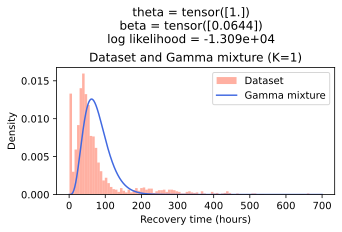

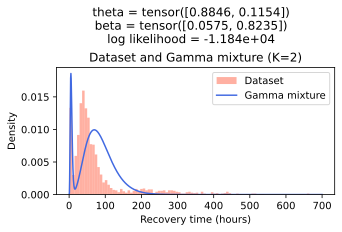

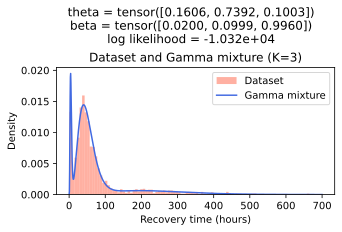

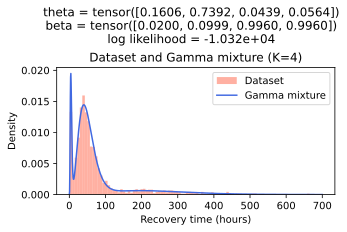

In [145]:
alpha = 5.0
for K in range(1,5):
    theta0 = torch.ones(K) / K
    betas0 = (torch.arange(K) + 1) / K
    theta, betas = run_em(theta0, betas0, verbose=False)
    make_overlay_plot(theta, betas)
    plt.savefig(f'img_output/p2_3_{K}mixtures.pdf', bbox_inches='tight')

---
## Problem 3

#### Initialize data:

In [147]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True)  # download MNIST
N = 6000 

x = mnist_trainset.data[:N]  # select N datapoints
x = x.flatten(1)             # flatten the images
x = x.float()                # convert pixels from uint8 to float
# x = x.numpy()              # uncomment to use numpy (optional)

RuntimeError: Error downloading train-images-idx3-ubyte.gz:
Tried http://yann.lecun.com/exdb/mnist/, got:
HTTP Error 404: Not Found
Tried https://ossci-datasets.s3.amazonaws.com/mnist/, got:
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1002)>


#### **Todo:** implement PCA

*Hint: see `.linalg.svd()`*

In [12]:
def pca(x, n_comps=500):
    # YOUR CODE HERE
    pass

#### **Todo:** calculate cumulative fraction of variance

*Hint: see `.cumsum()`*

In [13]:
def calc_cfvs(eigvals):
    # YOUR CODE HERE
    pass

#### **Todo:** calculate mean squared L2 norm reconstruction losses

In [14]:
def calc_errs(x, pcomps):
    # YOUR CODE HERE
    pass
    
    return err_mean, err_pcomp

#### Plot and print errors:

In [15]:
def plot_pic(pic, ax, title=''):
    x = pic.reshape(28, 28)
    ax.imshow(x, cmap='binary')
    ax.set_title(title)
    ax.axis('off')

def make_plots(eigvals, cfvs, x_mean, pcomps):
    # plot eigenvals and cfvs
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
    ax1.plot(eigvals, color='tomato')
    ax1.set_title('Eigenvalues')
    ax2.plot(cfvs, color='tomato')
    ax2.set_title('CFVs')
    fig.savefig('img_output/p3_cfvs.pdf')

    # plot mean
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    plot_pic(x_mean, ax, title='Mean')
    fig.savefig('img_output/p3_mean.pdf')

    # plot top 10 pcomps
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i in range(10):
        plot_pic(pcomps[i], axes.flat[i], title=f'PC index {i}')
    fig.savefig('img_output/p3_pcomps.pdf')

In [16]:
# do PCA
eigvals, pcomps = pca(x)

# calculate CFVs
fcvs = calc_cfvs(eigvals)

# print errors
err_mean, err_pcomp = calc_errs(x, pcomps)
print(f'Reconstruction error (using mean): {err_mean:3e}')  # 3.436022e+06
print(f'Reconstruction error (using mean and top 10 pcomps): {err_pcomp:3e}')  # 1.731315e+06

# make plots
make_plots(eigvals, fcvs, x.mean(0), pcomps)
